In [24]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline, CubicSpline, interp1d
from scipy.optimize import curve_fit
import time
import scipy


from openparticle.hamiltonians.free_hamiltonians import free_boson_Hamiltonian, free_fermion_Hamiltonian
from openparticle.hamiltonians.yukawa_hamiltonians import *
from openparticle.hamiltonians.renormalized_yukawa_hamiltonian import *
from openparticle.utils import *
from openparticle.dlcq import get_sector_basis, pdf, fock_sector_budget
from yukawa_utils import *

plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 24
plt.rc('text', usetex=True)
import warnings
warnings.filterwarnings('ignore')

In [25]:
#Universal parameters in all plots:
mf = 1
mb = 0.5

In [26]:
#M^2 Curve Fits

def m2_fit(x, a, b, c):
    return a + b/x + c/(x**2)

In [27]:
eigenvalues_boson_loop = []
eigenvalues_fermion_loop = []
eigenvalues_Q2 = []
resolutions_boson_loop = np.arange(1, 9, 1)
resolutions_fermion_loop = np.arange(1/2, 9, 1)
resolutions_Q2 = np.arange(3, 9, 1)

for res in resolutions_boson_loop:

    basis = impose_baryon_number(int(res), momentum_states_partition(res), 0)
    

    
    hamiltonian = yukawa_hamiltonian(
            res=int(res), g=1, mf=mf, mb=mb
        )

    tmp_mat = generate_matrix_hermitian(hamiltonian, basis)
    vals, vecs = np.linalg.eigh(tmp_mat)
    eigenvalues_boson_loop.append(min(vals))

for res in resolutions_fermion_loop:

    basis = impose_baryon_number(int(res + 1/2), momentum_states_partition(res), 1)
    hamiltonian = yukawa_hamiltonian(
            res=int(res + 1/2), g=1, mf=mf, mb=mb
        )
    tmp_mat = generate_matrix_hermitian(hamiltonian, basis)
    vals, vecs = np.linalg.eigh(tmp_mat)
    eigenvalues_fermion_loop.append(min(vals))

for res in resolutions_Q2:

    basis = impose_baryon_number(int(res), momentum_states_partition(res), 2)
    

    hamiltonian = yukawa_hamiltonian(
            res=int(res), g=1, mf=mf, mb=mb
        )

    tmp_mat = generate_matrix_hermitian(hamiltonian, basis)
    vals, vecs = np.linalg.eigh(tmp_mat)
    eigenvalues_Q2.append(min(vals))
    


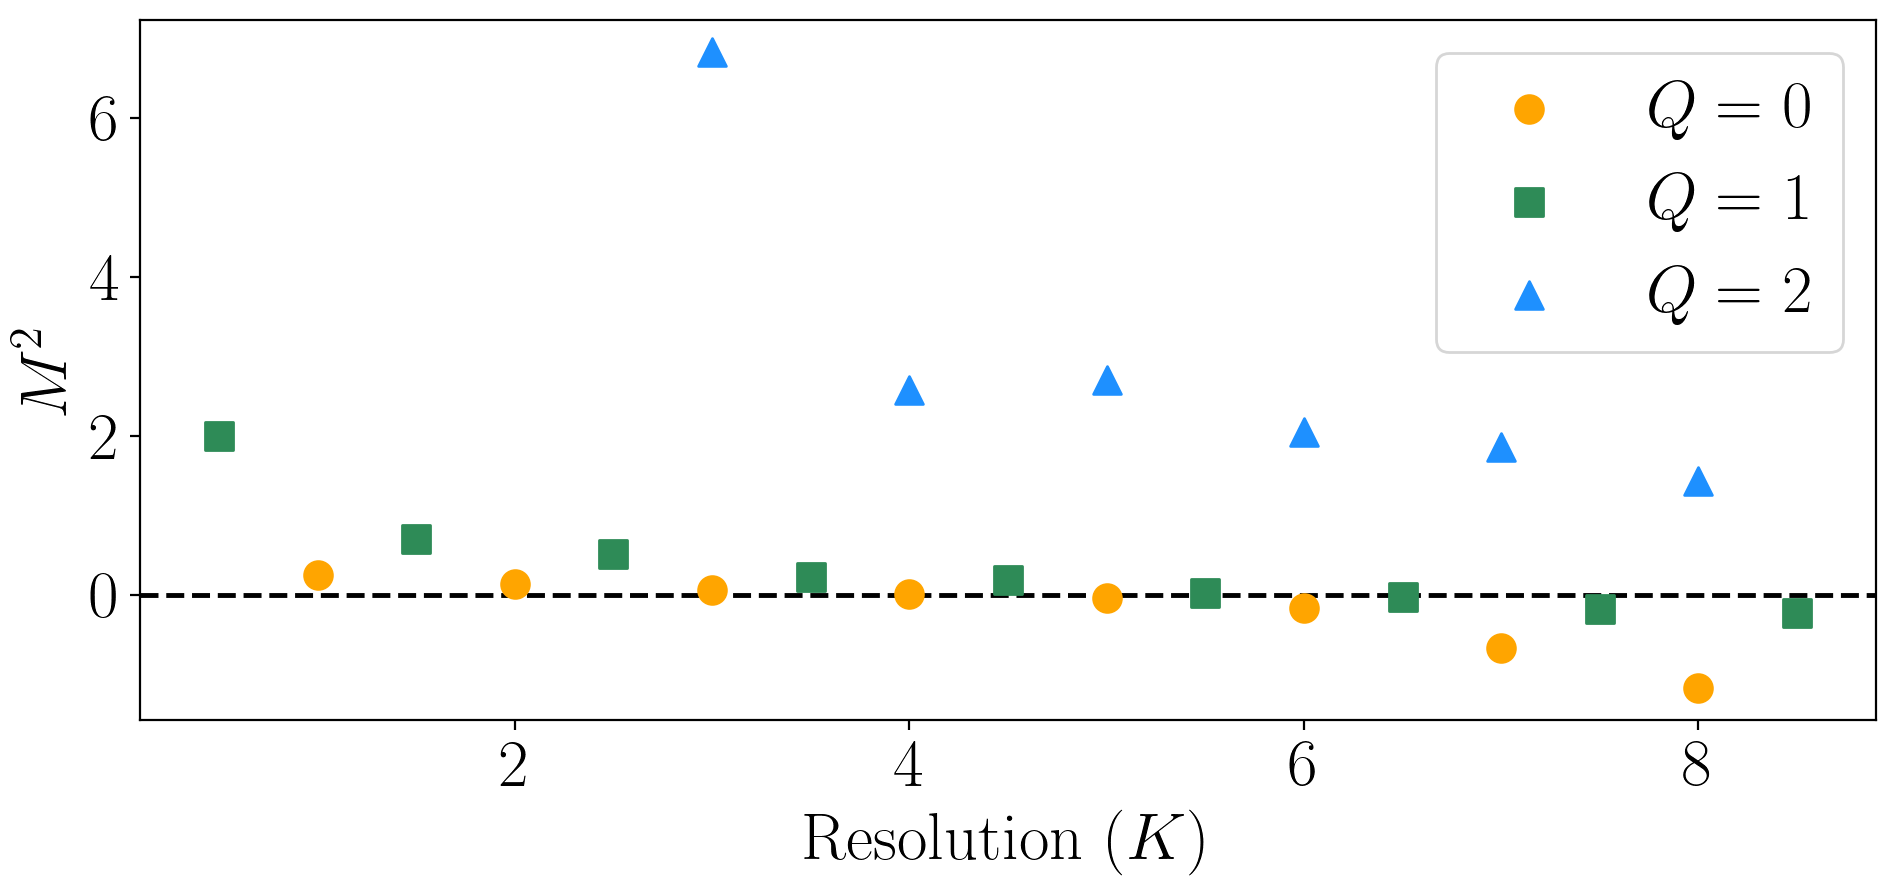

In [28]:
plt.figure(figsize=(10,5), dpi=200)
plt.scatter(resolutions_boson_loop, eigenvalues_boson_loop, color='orange', marker='o', s=100, label = r'$Q = 0$')
plt.scatter(resolutions_fermion_loop, eigenvalues_fermion_loop, color='seagreen', marker='s', s=100, label = r'$Q = 1$')
# plt.scatter(resolutions_Q2, eigenvalues_Q2, color=[(0,0.5,0.5)], marker='^', s=100, label = r'$Q = 2$')
plt.scatter(resolutions_Q2, eigenvalues_Q2, color='dodgerblue', marker='^', s=100, label = r'$Q = 2$')

plt.axhline(y=0, color='k', linewidth = 1.75, zorder = -1, linestyle = '--')

plt.xlabel(r"Resolution $(K)$")
plt.ylabel(r"$M^2$")
plt.legend()
plt.tight_layout()
# plt.title(r"Lowest $M^2$ Eigenvalue in Respective Sectors")

In [29]:
N = 200  # Number of grid points
x_max = 20 # Maximum x value (adjust as needed)
x_min = -20
dx = (x_max-x_min)/N
x = np.linspace(x_min, x_max, N+1)

def create_hamiltonian(V):
  c = 1 ** 2 / ( mf * dx ** 2)
  hamiltonian = np.zeros((N+1, N+1))
  for i in range(1, N - 1):
      hamiltonian[i, i] = 2 * c + V[i]
      hamiltonian[i, i + 1] = -c
      hamiltonian[i, i - 1] = -c
  return hamiltonian

bounds = []
mus = np.arange(0.1, 1, 1e-3)
for mu in mus:
    V = -0.3**2 / (2 * mu) * np.exp(-mu * np.abs(x))
    H=create_hamiltonian(V)

    # # Solve for eigenvalues and eigenvectors and sort
    # eigenvalues, eigenvectors = np.linalg.eig(H)
    # bounds.append(eigenvalues[eigenvalues < 0])
    eigenvalues, eigenvectors = np.linalg.eig(H)
    eigenvalues = np.sort(eigenvalues)  # Ensure sorted order
    bounds.append(eigenvalues[eigenvalues < 0])


padded_eigenvalues_plot_2_g1 = np.array(
    [
        np.pad(eig, (0, max(len(eig) for eig in bounds) - len(eig)), constant_values=np.nan)
        for eig in bounds
    ]
)


bounds = []
mus = np.arange(0.1, 1, 1e-3)
for mu in mus:
    V = -1.0**2 / (2 * mu) * np.exp(-mu * np.abs(x))
    H=create_hamiltonian(V)

    # # Solve for eigenvalues and eigenvectors and sort
    # eigenvalues, eigenvectors = np.linalg.eig(H)
    # bounds.append(eigenvalues[eigenvalues < 0])
    eigenvalues, eigenvectors = np.linalg.eig(H)
    eigenvalues = np.sort(eigenvalues)  # Ensure sorted order
    bounds.append(eigenvalues[eigenvalues < 0])


padded_eigenvalues_plot_2_g2 = np.array(
    [
        np.pad(eig, (0, max(len(eig) for eig in bounds) - len(eig)), constant_values=np.nan)
        for eig in bounds
    ]
)

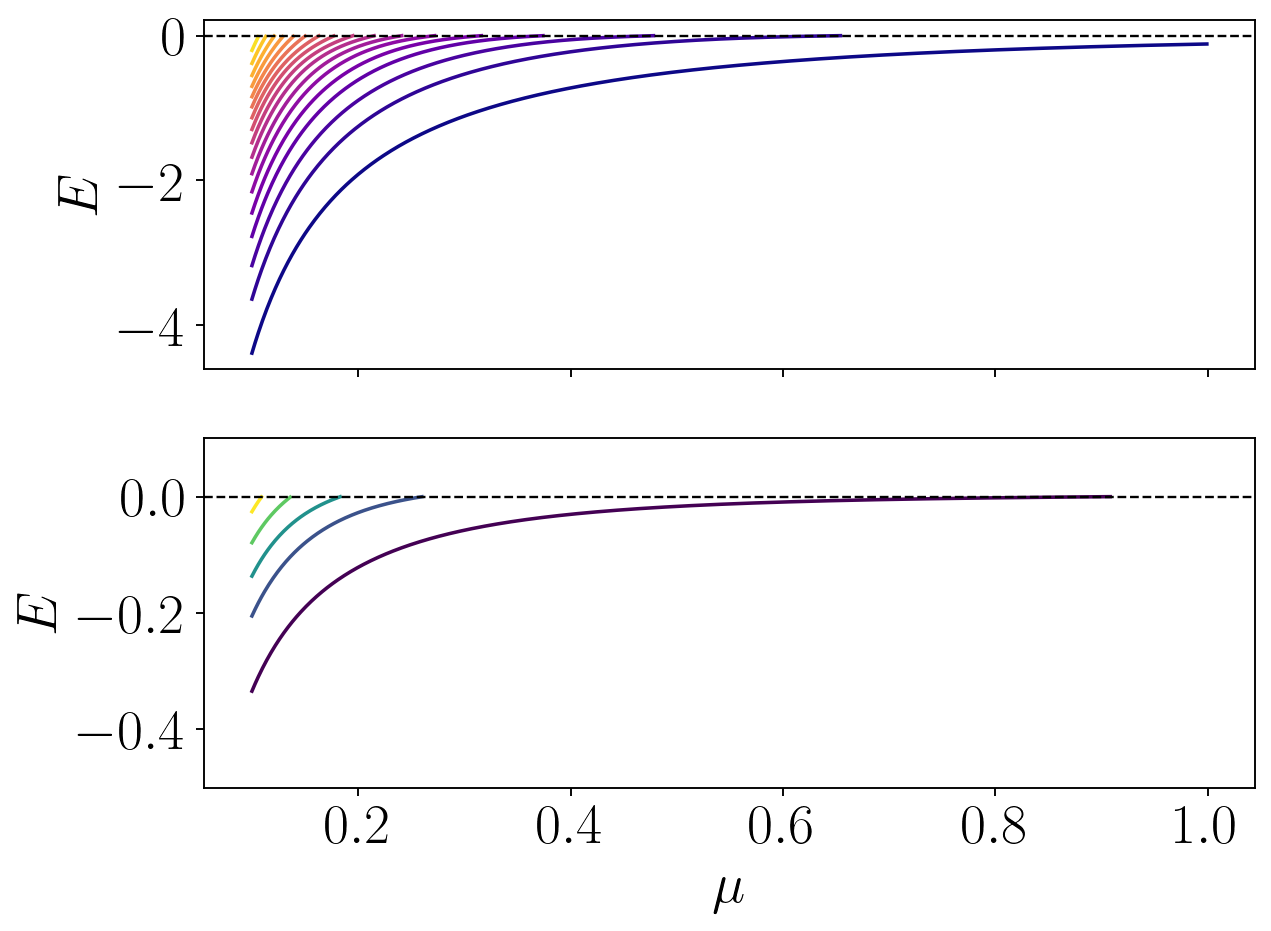

In [30]:
padded_eigenvalues_1 = padded_eigenvalues_plot_2_g1  
padded_eigenvalues_2 = padded_eigenvalues_plot_2_g2  


num_curves_1 = padded_eigenvalues_1.shape[1]
num_curves_2 = padded_eigenvalues_2.shape[1]

fig, axs = plt.subplots(2, 1, figsize=(8, 6), dpi=170, sharex=True)

cmap1 = plt.cm.get_cmap("viridis", num_curves_1)
cmap2 = plt.cm.get_cmap("plasma", num_curves_2)



for i in range(num_curves_2):
    axs[0].plot(mus, padded_eigenvalues_2[:, i], color=cmap2(i / max(1, num_curves_2 - 1)))
axs[0].axhline(y=0, linestyle='--', color='k', linewidth=1)
axs[0].set_ylabel(f"$E$")


for i in range(num_curves_1):
    axs[1].plot(mus, padded_eigenvalues_1[:, i], color=cmap1(i / max(1, num_curves_1 - 1)))
axs[1].axhline(y=0, linestyle='--', color='k', linewidth=1)
axs[1].set_ylabel(f"$E$")
axs[1].set_xlabel(f"$\mu$")
axs[1].set_ylim(-0.5, 0.1)

plt.tight_layout()

In [31]:
def t(Lambda):
    return 1/(Lambda**4)

def _lambda(t):
    return t**(-1/4)

In [42]:
max_K = 20

eigenvalues_f_fb_basis_g03 = []
eigenvalues_ff_ffb_basis_g03 = []

f_fb_resolutions = np.arange(1/2, max_K, 2)
ff_ffb_resolutions = np.arange(2, max_K + 1, 2)

for res in f_fb_resolutions:

    f_fb_basis = (
        get_sector_basis(resolution = res, n_fermions = 1, n_antifermions = 0, n_bosons = 0)
        + get_sector_basis(resolution = res, n_fermions = 1, n_antifermions = 0, n_bosons = 1)
    )  

    hamiltonian = renormalized_yukawa_hamiltonian(
            res=res, t=1e-12, treg=0, g=0.3, mf=mf, mb=mb, verbose=False
        )

    tmp_mat = generate_matrix_hermitian(hamiltonian, f_fb_basis)
    vals, vecs = np.linalg.eigh(tmp_mat)
    eigenvalues_f_fb_basis_g03.append(min(vals))

for res in ff_ffb_resolutions:

    ff_ffb_basis = (
        get_sector_basis(resolution = res, n_fermions = 2, n_antifermions = 0, n_bosons = 0)
        + get_sector_basis(resolution = res, n_fermions = 2, n_antifermions = 0, n_bosons = 1)
    )  

    hamiltonian = renormalized_yukawa_hamiltonian(
            res=res, t=1e-12, treg=0, g=0.3, mf=mf, mb=mb, verbose=False
        )
    
    tmp_mat = generate_matrix_hermitian(hamiltonian, ff_ffb_basis)
    vals, vecs = np.linalg.eigh(tmp_mat)
    eigenvalues_ff_ffb_basis_g03.append(min(vals))

Text(0, 0.5, '$M^2$')

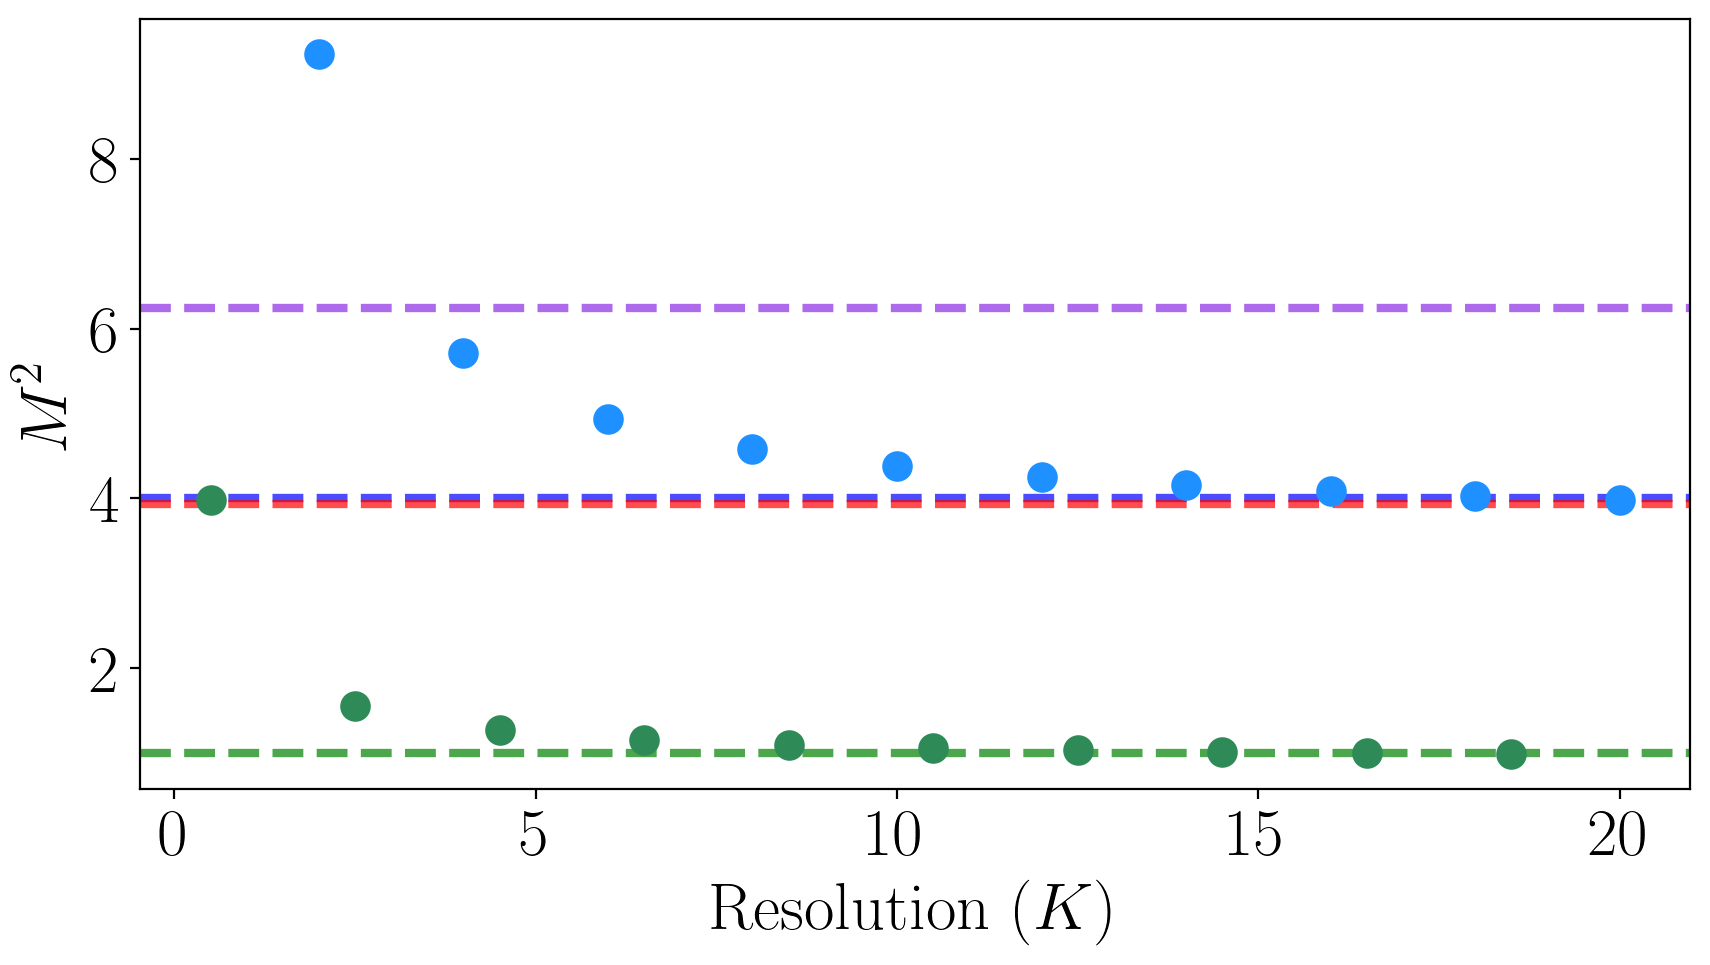

In [33]:
plt.figure(figsize=(10,5), dpi=200)

plt.scatter(f_fb_resolutions, eigenvalues_f_fb_basis_g03, marker = 'o', color = 'seagreen', s = 100)
plt.scatter(ff_ffb_resolutions, eigenvalues_ff_ffb_basis_g03, marker = 'o', color = 'dodgerblue', s = 100)

plt.axhline(y=mf**2, color='green', alpha = 0.7, linestyle = '--', linewidth = 3, zorder = -1)
plt.axhline(y=(2*mf)**2, color='blue', alpha = 0.7,linestyle = '--', linewidth = 3, zorder = -1)
plt.axhline(y=(2*mf + mb)**2, color='blueviolet', alpha = 0.7, linestyle = '--', linewidth = 3)
plt.axhline(y=min(nonrelativistic_yukawa(0.3, mf, mb)) * 2*2*mf + (2*mf)**2, color='r', alpha = 0.7,linestyle = '--', linewidth = 3, zorder = -1)

plt.xlabel(r"Resolution $(K)$")
plt.ylabel(r"$M^2$")

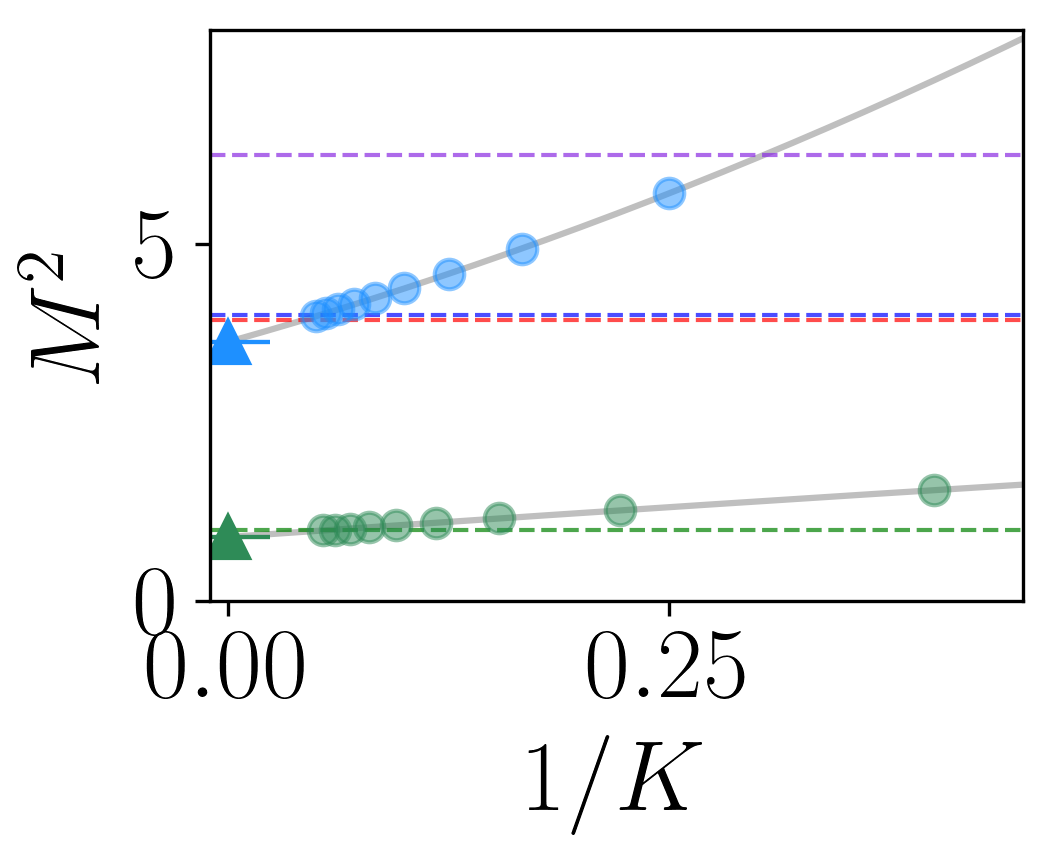

In [134]:
f_fb_curve = curve_fit(m2_fit, f_fb_resolutions[1:], eigenvalues_f_fb_basis_g03[1:])
ff_ffb_curve = curve_fit(m2_fit, ff_ffb_resolutions[1:], eigenvalues_ff_ffb_basis_g03[1:])

# plt.figure(figsize=(10,5), dpi=200)
plt.figure(figsize=(3.375, 2.75), dpi=300)


ks = np.arange(0, 2, 0.01)

plt.scatter(1/f_fb_resolutions[1:], eigenvalues_f_fb_basis_g03[1:], marker = 'o', color = 'seagreen', s = 50, alpha = 0.5)
plt.plot(ks, m2_fit(1/ks, *f_fb_curve[0]), alpha = 0.5, color = 'grey', zorder = -1)
plt.scatter(1/ff_ffb_resolutions[1:], eigenvalues_ff_ffb_basis_g03[1:], marker = 'o', color = 'dodgerblue', s = 50, alpha = 0.5)
plt.plot(ks, m2_fit(1/ks, *ff_ffb_curve[0]), alpha = 0.5, color = 'grey', zorder = -1)

plt.axhline(y=mf**2, color='green', alpha = 0.7, linestyle = '--', linewidth = 1, zorder = -1)
plt.axhline(y=(2*mf)**2, color='blue', alpha = 0.7,linestyle = '--', linewidth = 1, zorder = -1)
plt.axhline(y=(2*mf + mb)**2, color='blueviolet', alpha = 0.7, linestyle = '--', linewidth = 1, zorder = -1)
plt.axhline(y=min(nonrelativistic_yukawa(0.3, mf, mb)) * 2*2*mf + (2*mf)**2, color='r', alpha = 0.7,linestyle = '--', linewidth = 1, zorder = -1)


x = 0
y_f_fb = m2_fit(np.inf, *f_fb_curve[0])
y_f_fb_err = np.sqrt(np.diag(f_fb_curve[1]))[0]

y_ff_ffb = m2_fit(np.inf, *ff_ffb_curve[0])
y_ff_ffb_bare = np.sqrt(np.diag(ff_ffb_curve[1]))[0]

plt.errorbar(x, y_f_fb, yerr=y_f_fb_err, fmt='^', color = 'seagreen', capsize=10, label=f"{y_f_fb.round(3)}", ms = 10)
plt.errorbar(x, y_ff_ffb, yerr=y_ff_ffb_bare, fmt='^', color = 'dodgerblue', capsize=10, label=f"{y_ff_ffb.round(3)}", ms = 10)


plt.xlim(-0.01, 0.45)
plt.ylim(-0, 8)
plt.xlabel(r"$1/K$")
plt.ylabel(r"$M^2$")


plt.tight_layout(pad = 0.1)

In [135]:
print("Extrapolated Values (g = 0.3):")
print("m_f = ", m2_fit(np.inf, *f_fb_curve[0]))
print("M_{ff}^2 = ", m2_fit(np.inf, *ff_ffb_curve[0]))

Extrapolated Values (g = 0.3):
m_f =  0.8956310463537749
M_{ff}^2 =  3.628395058803236


In [136]:
max_K = 20

eigenvalues_f_fb_basis_g03 = []
eigenvalues_ff_ffb_basis_g03 = []

f_fb_resolutions = np.arange(1/2, max_K, 2)
ff_ffb_resolutions = np.arange(2, max_K + 1, 2)

for res in f_fb_resolutions:

    f_fb_basis = (
        get_sector_basis(resolution = res, n_fermions = 1, n_antifermions = 0, n_bosons = 0)
        + get_sector_basis(resolution = res, n_fermions = 1, n_antifermions = 0, n_bosons = 1)
    )  

    hamiltonian = renormalized_yukawa_hamiltonian(
            res=res, t=1e-12, treg=0, g=1.0, mf=mf, mb=mb, verbose=False
        )

    tmp_mat = generate_matrix_hermitian(hamiltonian, f_fb_basis)
    vals, vecs = np.linalg.eigh(tmp_mat)
    eigenvalues_f_fb_basis_g03.append(min(vals))

for res in ff_ffb_resolutions:

    ff_ffb_basis = (
        get_sector_basis(resolution = res, n_fermions = 2, n_antifermions = 0, n_bosons = 0)
        + get_sector_basis(resolution = res, n_fermions = 2, n_antifermions = 0, n_bosons = 1)
    )  

    hamiltonian = renormalized_yukawa_hamiltonian(
            res=res, t=1e-12, treg=0, g=1.0, mf=mf, mb=mb, verbose=False
        )
    
    tmp_mat = generate_matrix_hermitian(hamiltonian, ff_ffb_basis)
    vals, vecs = np.linalg.eigh(tmp_mat)
    eigenvalues_ff_ffb_basis_g03.append(min(vals))

Text(0, 0.5, '$M^2$')

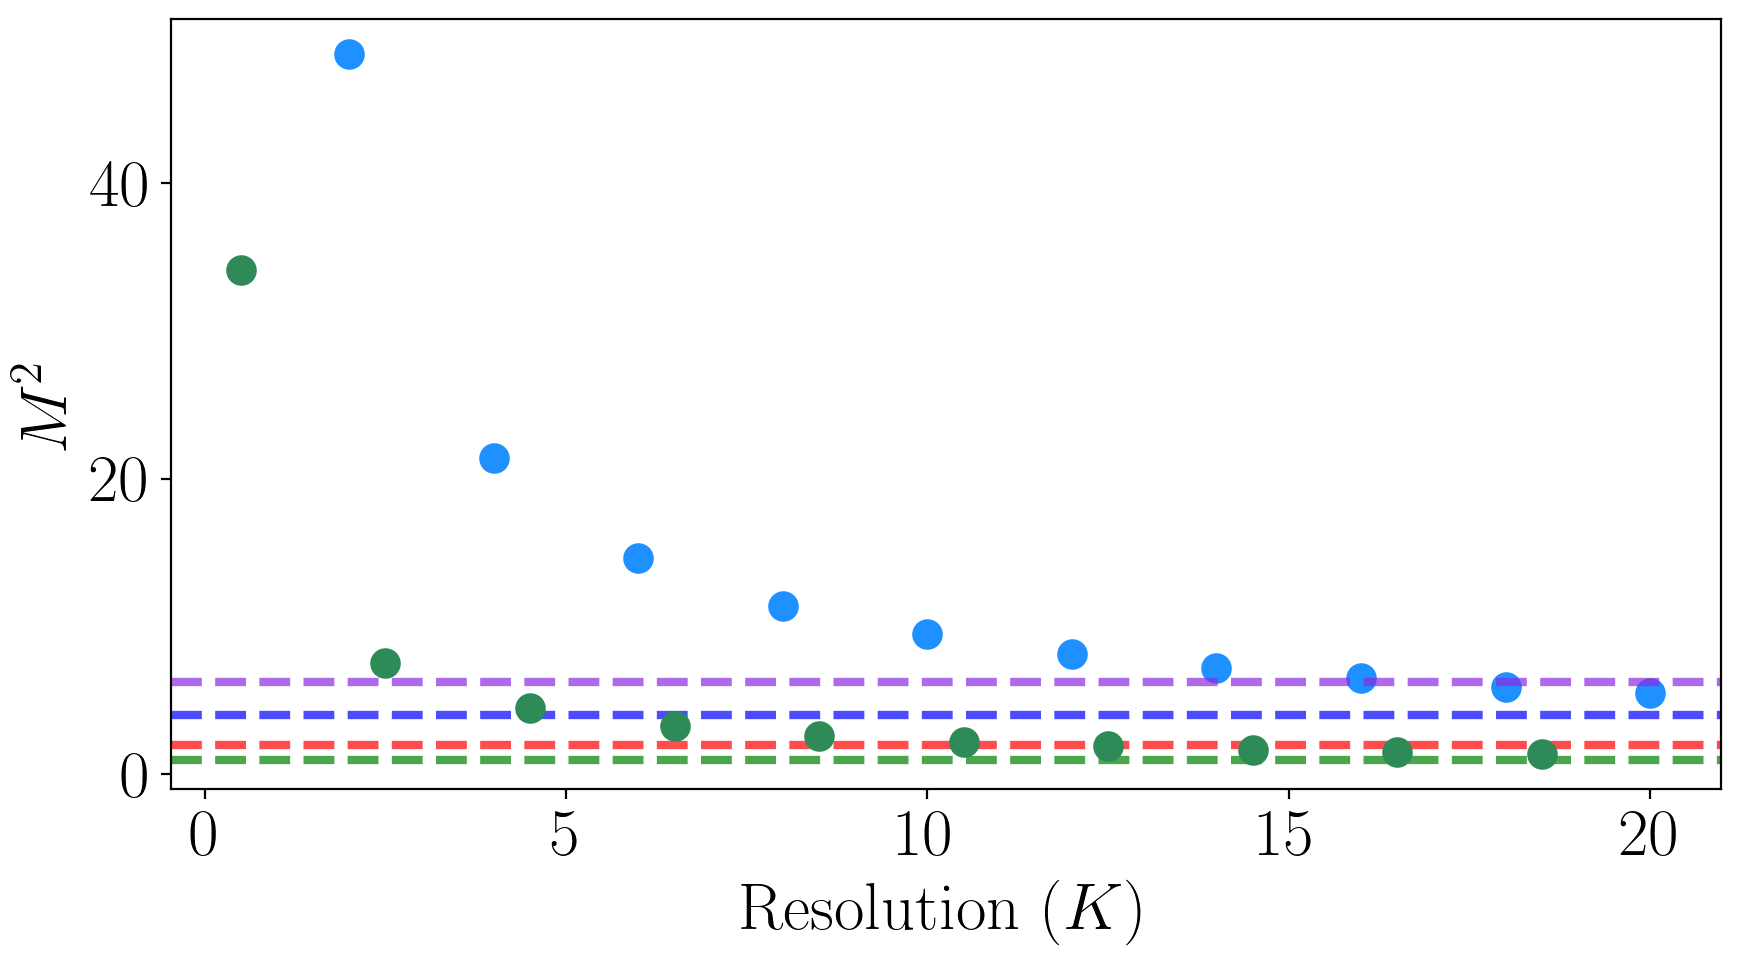

In [137]:
plt.figure(figsize=(10,5), dpi=200)

plt.scatter(f_fb_resolutions, eigenvalues_f_fb_basis_g03, marker = 'o', color = 'seagreen', s = 100)
plt.scatter(ff_ffb_resolutions, eigenvalues_ff_ffb_basis_g03, marker = 'o', color = 'dodgerblue', s = 100)

plt.axhline(y=mf**2, color='green', alpha = 0.7, linestyle = '--', linewidth = 3, zorder = -1)
plt.axhline(y=(2*mf)**2, color='blue', alpha = 0.7,linestyle = '--', linewidth = 3, zorder = -1)
plt.axhline(y=(2*mf + mb)**2, color='blueviolet', alpha = 0.7, linestyle = '--', linewidth = 3)
plt.axhline(y=min(nonrelativistic_yukawa(1.0, mf, mb)) * 2*2*mf + (2*mf)**2, color='r', alpha = 0.7,linestyle = '--', linewidth = 3, zorder = -1)

plt.xlabel(r"Resolution $(K)$")
plt.ylabel(r"$M^2$")

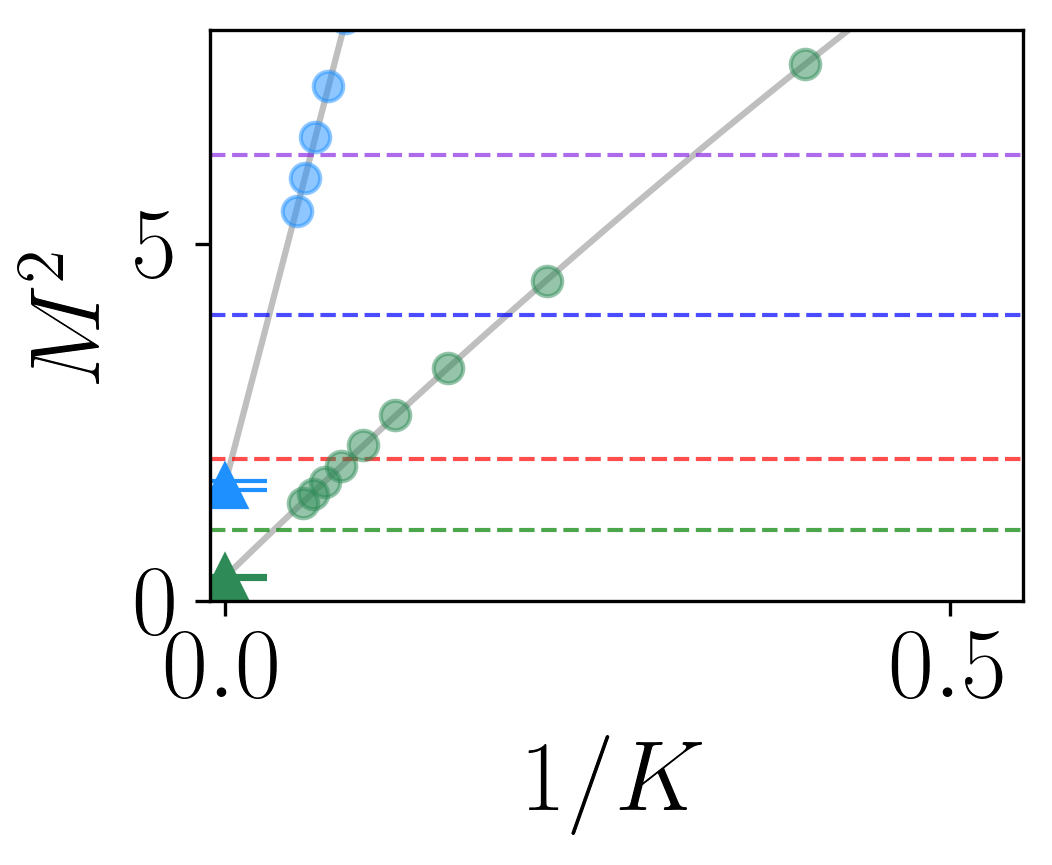

In [139]:
f_fb_curve = curve_fit(m2_fit, f_fb_resolutions[1:], eigenvalues_f_fb_basis_g03[1:])
ff_ffb_curve = curve_fit(m2_fit, ff_ffb_resolutions[1:], eigenvalues_ff_ffb_basis_g03[1:])

# plt.figure(figsize=(10,5), dpi=170)
plt.figure(figsize=(3.375, 2.75), dpi=300)

ks = np.arange(0, 2, 0.01)

plt.scatter(1/f_fb_resolutions[1:], eigenvalues_f_fb_basis_g03[1:], marker = 'o', color = 'seagreen', s = 50, alpha = 0.5)
plt.plot(ks, m2_fit(1/ks, *f_fb_curve[0]), alpha = 0.5, color = 'grey', zorder = -1)
plt.scatter(1/ff_ffb_resolutions[1:], eigenvalues_ff_ffb_basis_g03[1:], marker = 'o', color = 'dodgerblue', s = 50, alpha = 0.5)
plt.plot(ks, m2_fit(1/ks, *ff_ffb_curve[0]), alpha = 0.5, color = 'grey', zorder = -1)

plt.axhline(y=mf**2, color='green', alpha = 0.7, linestyle = '--', linewidth = 1, zorder = -1)
plt.axhline(y=(2*mf)**2, color='blue', alpha = 0.7,linestyle = '--', linewidth = 1, zorder = -1)
plt.axhline(y=(2*mf + mb)**2, color='blueviolet', alpha = 0.7, linestyle = '--', linewidth = 1, zorder = -1)
plt.axhline(y=min(nonrelativistic_yukawa(1.0, mf, mb)) * 2*2*mf + (2*mf)**2, color='r', alpha = 0.7,linestyle = '--', linewidth = 1, zorder = -1)


x = 0
y_f_fb = m2_fit(np.inf, *f_fb_curve[0])
y_f_fb_err = np.sqrt(np.diag(f_fb_curve[1]))[0]

y_ff_ffb = m2_fit(np.inf, *ff_ffb_curve[0])
y_ff_ffb_bare = np.sqrt(np.diag(ff_ffb_curve[1]))[0]

plt.errorbar(x, y_f_fb, yerr=y_f_fb_err, fmt='^', color = 'seagreen', capsize=10, label=f"{y_f_fb.round(3)}", ms = 10)
plt.errorbar(x, y_ff_ffb, yerr=y_ff_ffb_bare, fmt='^', color = 'dodgerblue', capsize=10, label=f"{y_ff_ffb.round(3)}", ms = 10)


plt.xlim(-0.01, 0.55)
plt.ylim(-0, 8)
plt.xlabel(r"$1/K$")
plt.ylabel(r"$M^2$")


plt.tight_layout(pad = 0.1)

In [39]:
print("Extrapolated Values (g = 0.3):")
print("m_f = ", m2_fit(np.inf, *f_fb_curve[0]))
print("M_{ff}^2 = ", m2_fit(np.inf, *ff_ffb_curve[0]))

Extrapolated Values (g = 0.3):
m_f =  0.33040028420820783
M_{ff}^2 =  1.6161825895788575


In [ ]:
ff_ffb_resolutions = np.arange(2, 34 + 1, 2)


ff_ffb_basis = (
    get_sector_basis(resolution = 34, n_fermions = 2, n_antifermions = 0, n_bosons = 0)
    + get_sector_basis(resolution = 34, n_fermions = 2, n_antifermions = 0, n_bosons = 1)
)  

hamiltonian = renormalized_yukawa_hamiltonian(
        res=34, t=1e-12, treg=0, g=1, mf=mf, mb=mb, verbose=False
    )

tmp_mat = generate_matrix_hermitian(hamiltonian, ff_ffb_basis)
vals, vecs = np.linalg.eigh(tmp_mat)

Text(0, 0.5, '$f_i$')

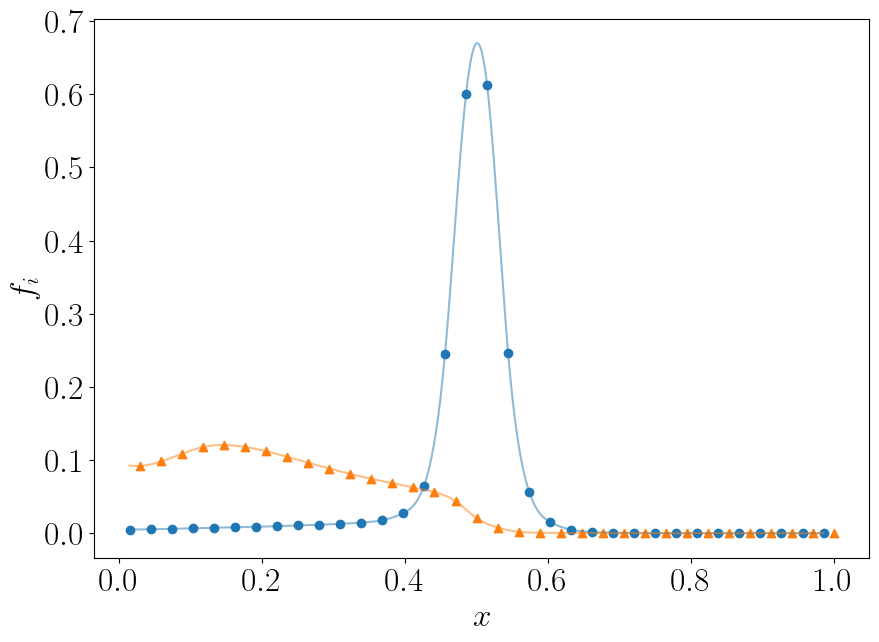

In [ ]:
from scipy.interpolate import PchipInterpolator

eigenstate = 0

psi = numpy_to_fock(vecs[:, eigenstate], ff_ffb_basis)

fermion_pdf = pdf(34, psi, 'fermion')
boson_pdf = pdf(34, psi, 'boson')

x_fermion = np.array([k/34 for k in np.arange(1/2, 34, 1)])
x_boson = np.array([k/34 for k in np.arange(1, 34 + 1, 1)])

xnew = np.arange(min(x_fermion), max(x_fermion), 0.001)

plt.figure(figsize = (10, 7), dpi = 100)

fermion_interp = CubicSpline(x_fermion, fermion_pdf)
boson_interp = CubicSpline(x_boson, boson_pdf)

plt.scatter(x_fermion, np.real(fermion_pdf), label = f'Fermion')
plt.plot(xnew, fermion_interp(xnew), alpha = 0.5)

plt.scatter(x_boson,10*np.real(boson_pdf),   label = r'$10 \times $Boson', marker = '^')
plt.plot(xnew, 10*boson_interp(xnew), alpha = 0.5)
# plt.legend()
plt.xlabel(f'$x$')
plt.ylabel(f'$f_i$')

In [ ]:
ts = [1e-14, 1e-12, 1e-10, 1e-8, 1e-6, 1e-4, 1e-2, 1e0, 1]


half_integer_Ks = np.arange(1/2, 20, 2)
integer_Ks = np.arange(2, 20, 2)


f_fb_fits = []
ff_ffb_fits = []

for t in ts:
    eigenvalues_f_fb_basis = []
    eigenvalues_ff_ffb_basis = []

    #f + fb
    
    for res in half_integer_Ks:
        f_fb_basis = (
            get_sector_basis(resolution = res, n_fermions = 1, n_antifermions = 0, n_bosons = 0)#res - 1/2
            + get_sector_basis(resolution = res, n_fermions = 1, n_antifermions = 0, n_bosons = 1)#res - 1/2
        )  
        hamiltonian = renormalized_yukawa_hamiltonian(res = res, t = t, treg = 0, g = 0.3, mf = mf, mb = mb)
        tmp_mat = generate_matrix_hermitian(hamiltonian, f_fb_basis)
        vals = np.linalg.eigvalsh(tmp_mat)
        eigenvalues_f_fb_basis.append(min(vals))

    params = curve_fit(m2_fit, half_integer_Ks, eigenvalues_f_fb_basis)
    f_fb_fits.append(m2_fit(np.inf, *params[0]))

        

    #ff + ffb
    
    for res in integer_Ks:
        ff_ffb_basis = (
            get_sector_basis(resolution = res, n_fermions = 2, n_antifermions = 0, n_bosons = 0)
            + get_sector_basis(resolution = res, n_fermions = 2, n_antifermions = 0, n_bosons = 1)
        )  
        hamiltonian = renormalized_yukawa_hamiltonian(res = res, t = t, treg = 0, g = 0.3, mf = mf, mb = mb)
        tmp_mat = generate_matrix_hermitian(hamiltonian, ff_ffb_basis)
        vals = np.linalg.eigvalsh(tmp_mat)
        eigenvalues_ff_ffb_basis.append(min(vals))
    params = curve_fit(m2_fit, integer_Ks, eigenvalues_ff_ffb_basis)
    ff_ffb_fits.append(m2_fit(np.inf, *params[0]))



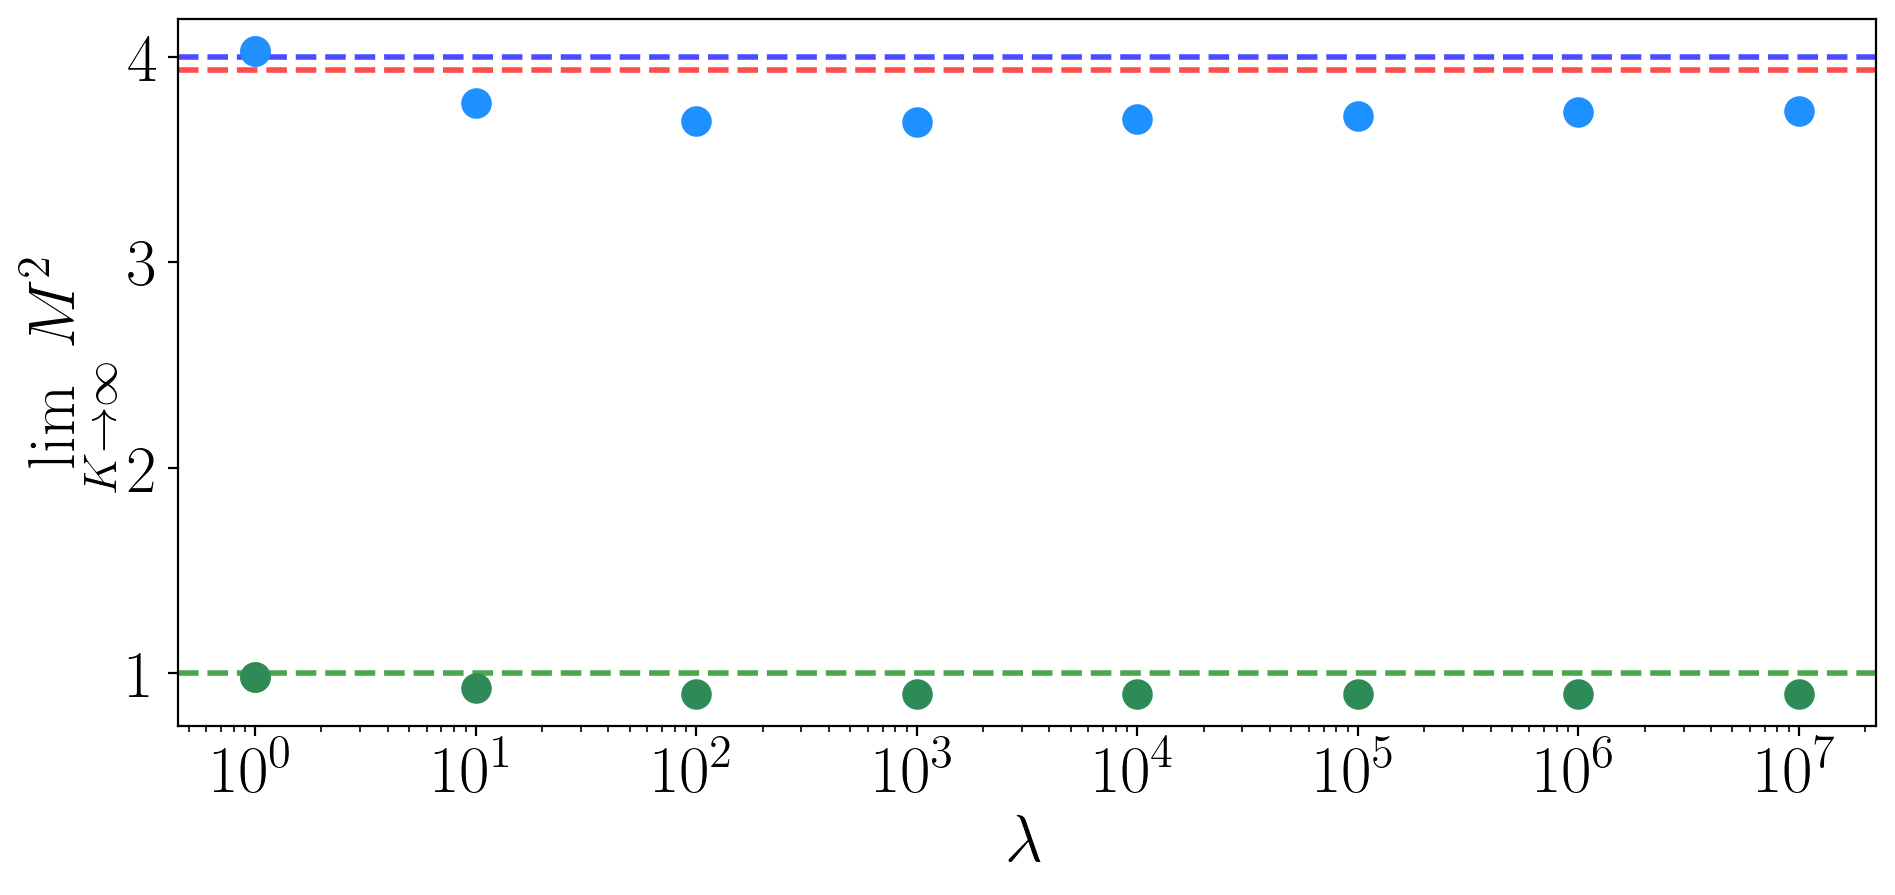

In [ ]:
lambdas = 1/np.sqrt(np.array(ts))

plt.figure(figsize=(10,5), dpi=200)
plt.axhline(y = mf**2, color = 'green', linestyle = '--', alpha = 0.7, linewidth = 2,zorder = -1)
plt.axhline(y = 4*mf**2, color = 'blue', linestyle = '--', alpha = 0.7, linewidth = 2,zorder = -1)
plt.axhline(y=min(nonrelativistic_yukawa(0.3, mf, mb)) * 2*2*mf + (2*mf)**2, color='r', alpha = 0.7,linestyle = '--', linewidth = 2, zorder = -1)
plt.scatter(lambdas, f_fb_fits, color = 'seagreen', s = 100)
plt.scatter(lambdas, ff_ffb_fits, color = 'dodgerblue', s = 100)
plt.ylabel(r"$\lim\limits_{K \rightarrow \infty} M^2$")
plt.xlabel(f"$\lambda$")
plt.xscale('log')
plt.tight_layout()

In [ ]:
ts = [1e-14, 1e-12, 1e-10, 1e-8,  1e-6,  1e-4,  1e-2,  1, 100]

half_integer_Ks = np.arange(1/2, 22, 2)
# integer_Ks = np.arange(3, 22, 1)
integer_Ks = [22]


f_fb_fits = []
ff_ffb_fits = []

for t in ts:
    eigenvalues_ff_ffb_basis = []

        

    #ff + ffb
    
    for res in integer_Ks:
        ff_ffb_basis = (
            get_sector_basis(resolution = res, n_fermions = 2, n_antifermions = 0, n_bosons = 0)
            + get_sector_basis(resolution = res, n_fermions = 2, n_antifermions = 0, n_bosons = 1)
            + get_sector_basis(resolution = res, n_fermions = 3, n_antifermions = 1, n_bosons = 0)
            + get_sector_basis(resolution = res, n_fermions = 2, n_antifermions = 0, n_bosons = 2)
        )  
        hamiltonian = renormalized_yukawa_hamiltonian(res = res, t = t, treg = 0, g = 0.5, mf = mf, mb = mb)
        tmp_mat = generate_matrix_hermitian(hamiltonian, ff_ffb_basis)
        vals = np.linalg.eigvalsh(tmp_mat)

        eigenvalues_ff_ffb_basis.append(sorted(vals))
    length = max(map(len, eigenvalues_ff_ffb_basis))
    y=np.array([xi+[None]*(length-len(xi)) for xi in eigenvalues_ff_ffb_basis])
    ff_ffb_fits_fixed_t = []
    for curve in y.T:
        ff_ffb_fits_fixed_t.append(curve[-1])

    ff_ffb_fits.append(ff_ffb_fits_fixed_t)

for res in integer_Ks:
    ff_ffb_basis = (
        get_sector_basis(resolution = res, n_fermions = 2, n_antifermions = 0, n_bosons = 0)
        + get_sector_basis(resolution = res, n_fermions = 2, n_antifermions = 0, n_bosons = 1)
        + get_sector_basis(resolution = res, n_fermions = 3, n_antifermions = 1, n_bosons = 0)
        + get_sector_basis(resolution = res, n_fermions = 2, n_antifermions = 0, n_bosons = 2)
    )  
    # hamiltonian = renormalized_yukawa_hamiltonian(res = res, t = t, treg = 0, g = 0, mf = mf, mb = mb)
    hamiltonian = free_boson_Hamiltonian(res = res, mb = mb) + free_fermion_Hamiltonian(res = res, mf = mf)
    tmp_mat_free = generate_matrix_hermitian(hamiltonian, ff_ffb_basis)
    vals_free = np.linalg.eigvalsh(tmp_mat_free)

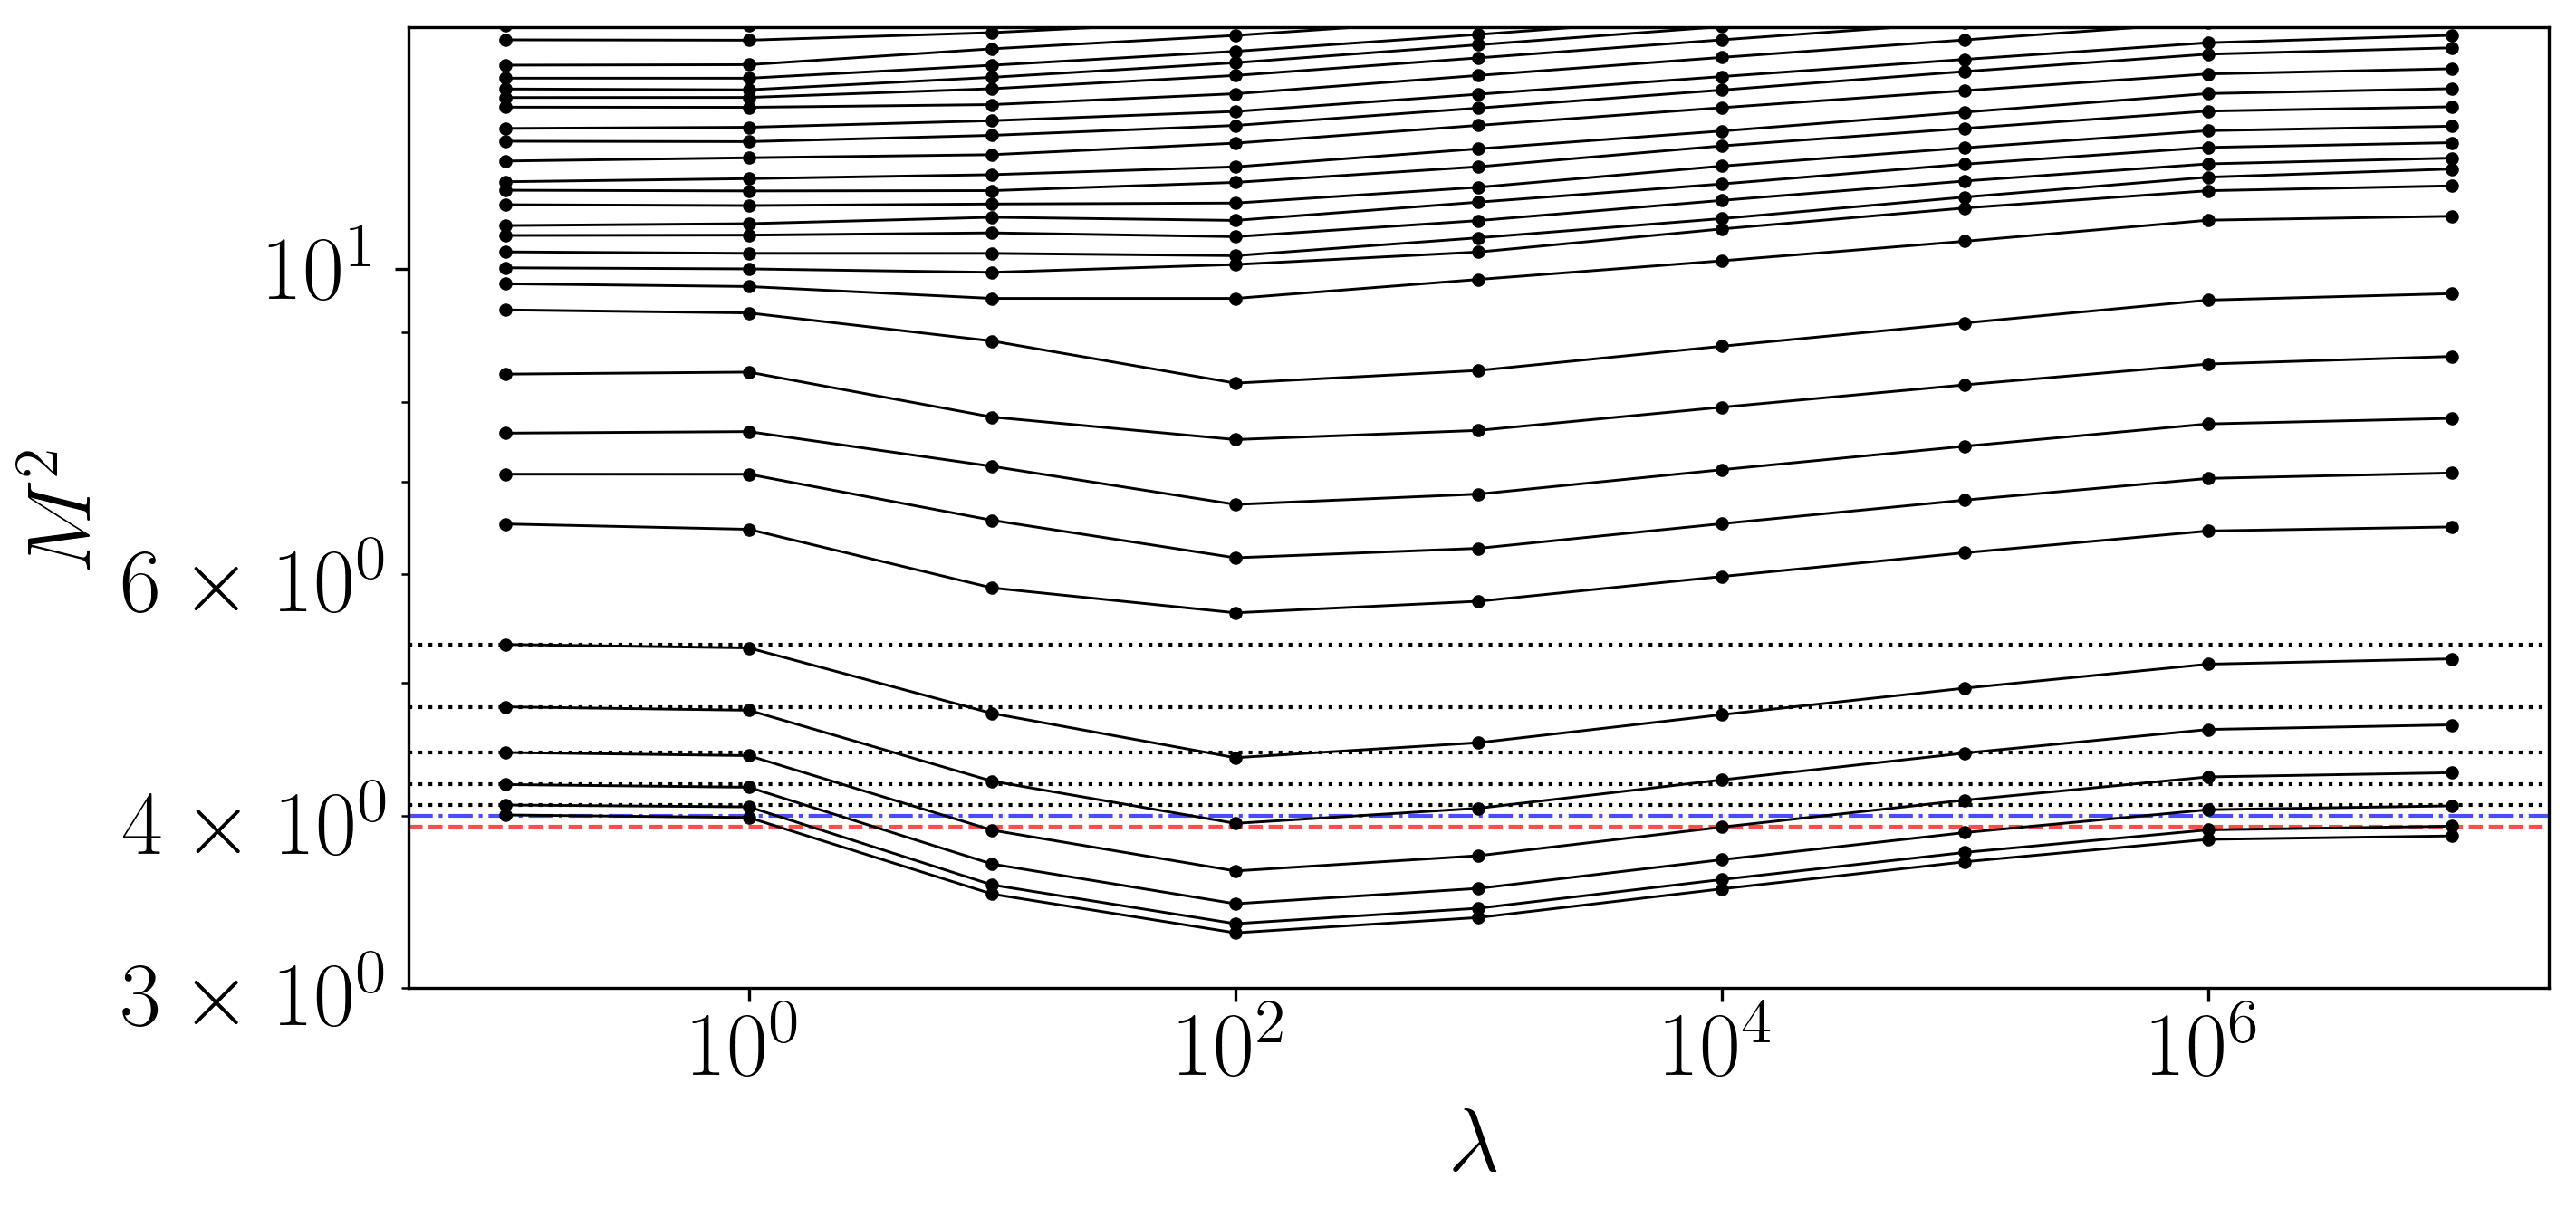

In [ ]:
lambdas = 1/np.sqrt(ts)
colors = plt.cm.viridis(np.linspace(0, 1, len(np.array(ff_ffb_fits)[0][np.array(ff_ffb_fits)[0] != None])))
fig, ax = plt.subplots()
fig.set_size_inches(10,5)
fig.set_dpi(300)


for i, curve in enumerate(np.array(ff_ffb_fits).T):
    if i <= 5 or (i > 5 and i % 10 == 0):
        ax.plot(lambdas, np.array(curve), color = 'k', linewidth = 0.7, marker = '.', markeredgecolor = 'black', zorder = 2, markeredgewidth = 0.5)
    
ax.axhline(y = 4*mf**2, color = 'blue', linestyle = '-.', alpha = 0.7, linewidth = 1,zorder = -1)
ax.axhline(y=min(nonrelativistic_yukawa(0.3, mf, mb)) * 2*2*mf + (2*mf)**2, color='r', alpha = 0.7,linestyle = '--', linewidth = 1, zorder = -1)
ax.set_ylabel(f"$M^2$")
ax.set_xlabel(r"$\lambda$")
ax.set_xscale('log')
for eigenvalue in range(1, 6):
    plt.axhline(y = vals_free[eigenvalue], linestyle = 'dotted', alpha = 1, linewidth = 1, color = 'k', zorder = -1)


plt.yscale('log')
plt.ylim(3, 15)
plt.tight_layout()
plt.show()

In [54]:
mf = 1
mb = 0.5
t = 1e-12




Ks_f_fb = np.arange(1/2, 20, 2)
Ks_ff_ffb = np.arange(2, 21, 2)

ms_Q1 = []
ms_Q2 = []

gs = np.arange(0., 1.1, 0.1)
for g in gs:
    eigenvalues_f_fb_basis = []
    eigenvalues_ff_ffb_basis = []
    for res in Ks_f_fb:
        
        basis = (
            get_sector_basis(resolution = res, n_fermions = 1, n_antifermions = 0, n_bosons = 0)
            + get_sector_basis(resolution = res, n_fermions = 1, n_antifermions = 0, n_bosons = 1)
        )   
        
        hamiltonian = renormalized_yukawa_hamiltonian(
                res=res, t=t, treg=0, g=g, mf=mf, mb=mb, verbose=False
            )
        tmp_mat = generate_matrix_hermitian(hamiltonian, basis)
        vals = np.linalg.eigvalsh(tmp_mat)
        eigenvalues_f_fb_basis.append(min(vals))
    
    for res in Ks_ff_ffb:
        
        basis = (
            get_sector_basis(resolution = res, n_fermions = 2, n_antifermions = 0, n_bosons = 0)
            + get_sector_basis(resolution = res, n_fermions = 2, n_antifermions = 0, n_bosons = 1)
        )   
        
        hamiltonian = renormalized_yukawa_hamiltonian(
                res=res, t=t, treg=0, g=g, mf=mf, mb=mb, verbose=False
            )
        tmp_mat = generate_matrix_hermitian(hamiltonian, basis)
        vals = np.linalg.eigvalsh(tmp_mat)
        eigenvalues_ff_ffb_basis.append(min(vals))

    params_1 = curve_fit(m2_fit, Ks_f_fb, eigenvalues_f_fb_basis)
    params_2 = curve_fit(m2_fit, Ks_ff_ffb, eigenvalues_ff_ffb_basis)

    ms_Q1.append(m2_fit(np.inf, *params_1[0]))
    ms_Q2.append(m2_fit(np.inf, *params_2[0]))

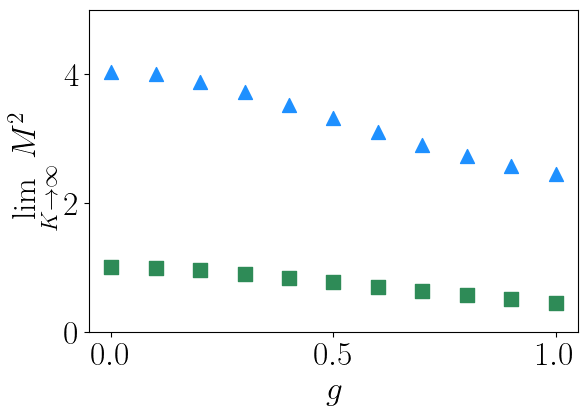

In [58]:
plt.scatter(gs, ms_Q1, color='seagreen', marker='s', s=100, label = r'$Q = 1$')
plt.scatter(gs, ms_Q2, color='dodgerblue', marker='^', s=100, label = r'$Q = 1$')

plt.ylabel(r"$\lim\limits_{K \rightarrow \infty}M^2$")
plt.xlabel(f"$g$")
plt.ylim(0, 5)
plt.tight_layout()
# plt.savefig("/Users/carterm.gustin/Downloads/M2_vs_g.pdf")

In [110]:
mf = 1
mb = 0.5

K = 20
gs = np.arange(0., 1.1, 0.1)
ts = [1e-14, 1e-12, 1e-10, 1e-8, 1e-6, 1e-4, 1e-2, 1e0, 10]


Ks_f_fb = np.arange(1/2, K, 2)
Ks_ff_ffb = np.arange(2, K + 1, 2)

ms_Q1 = np.zeros((len(gs), len(ts)))
ms_Q2 = np.zeros((len(gs), len(ts)))


for gi, g in enumerate(gs):
    for ti, t in enumerate(ts):
        print("g = ", g, "t = ", t)
        eigenvalues_f_fb_basis = []
        eigenvalues_ff_ffb_basis = []
        for res in Ks_f_fb:
            
            basis = (
                get_sector_basis(resolution = res, n_fermions = 1, n_antifermions = 0, n_bosons = 0)
                + get_sector_basis(resolution = res, n_fermions = 1, n_antifermions = 0, n_bosons = 1)
            )   
            
            hamiltonian = renormalized_yukawa_hamiltonian(
                    res=res, t=t, treg=0, g=g, mf=mf, mb=mb, verbose=False
                )
            tmp_mat = generate_matrix_hermitian(hamiltonian, basis)
            vals = np.linalg.eigvalsh(tmp_mat)
            eigenvalues_f_fb_basis.append(min(vals))
        
        for res in Ks_ff_ffb:
            
            basis = (
                get_sector_basis(resolution = res, n_fermions = 2, n_antifermions = 0, n_bosons = 0)
                + get_sector_basis(resolution = res, n_fermions = 2, n_antifermions = 0, n_bosons = 1)
            )   
            
            hamiltonian = renormalized_yukawa_hamiltonian(
                    res=res, t=t, treg=0, g=g, mf=mf, mb=mb, verbose=False
                )
            tmp_mat = generate_matrix_hermitian(hamiltonian, basis)
            vals = np.linalg.eigvalsh(tmp_mat)
            eigenvalues_ff_ffb_basis.append(min(vals))

        params_1 = curve_fit(m2_fit, Ks_f_fb, eigenvalues_f_fb_basis)
        params_2 = curve_fit(m2_fit, Ks_ff_ffb, eigenvalues_ff_ffb_basis)

        ms_Q1[gi, ti] = (m2_fit(np.inf, *params_1[0]))
        ms_Q2[gi, ti] = (m2_fit(np.inf, *params_2[0]))

g =  0.0 t =  1e-14
g =  0.0 t =  1e-12
g =  0.0 t =  1e-10
g =  0.0 t =  1e-08
g =  0.0 t =  1e-06
g =  0.0 t =  0.0001
g =  0.0 t =  0.01
g =  0.0 t =  1.0
g =  0.0 t =  10
g =  0.1 t =  1e-14
g =  0.1 t =  1e-12
g =  0.1 t =  1e-10
g =  0.1 t =  1e-08
g =  0.1 t =  1e-06
g =  0.1 t =  0.0001
g =  0.1 t =  0.01
g =  0.1 t =  1.0
g =  0.1 t =  10
g =  0.2 t =  1e-14
g =  0.2 t =  1e-12
g =  0.2 t =  1e-10
g =  0.2 t =  1e-08
g =  0.2 t =  1e-06
g =  0.2 t =  0.0001
g =  0.2 t =  0.01
g =  0.2 t =  1.0
g =  0.2 t =  10
g =  0.30000000000000004 t =  1e-14
g =  0.30000000000000004 t =  1e-12
g =  0.30000000000000004 t =  1e-10
g =  0.30000000000000004 t =  1e-08
g =  0.30000000000000004 t =  1e-06
g =  0.30000000000000004 t =  0.0001
g =  0.30000000000000004 t =  0.01
g =  0.30000000000000004 t =  1.0
g =  0.30000000000000004 t =  10
g =  0.4 t =  1e-14
g =  0.4 t =  1e-12
g =  0.4 t =  1e-10
g =  0.4 t =  1e-08
g =  0.4 t =  1e-06
g =  0.4 t =  0.0001
g =  0.4 t =  0.01
g =  0.4 t =  1.

In [115]:
lambdas

array([1.00000000e+07, 1.00000000e+06, 1.00000000e+05, 1.00000000e+04,
       1.00000000e+03, 1.00000000e+02, 1.00000000e+01, 1.00000000e+00,
       3.16227766e-01])

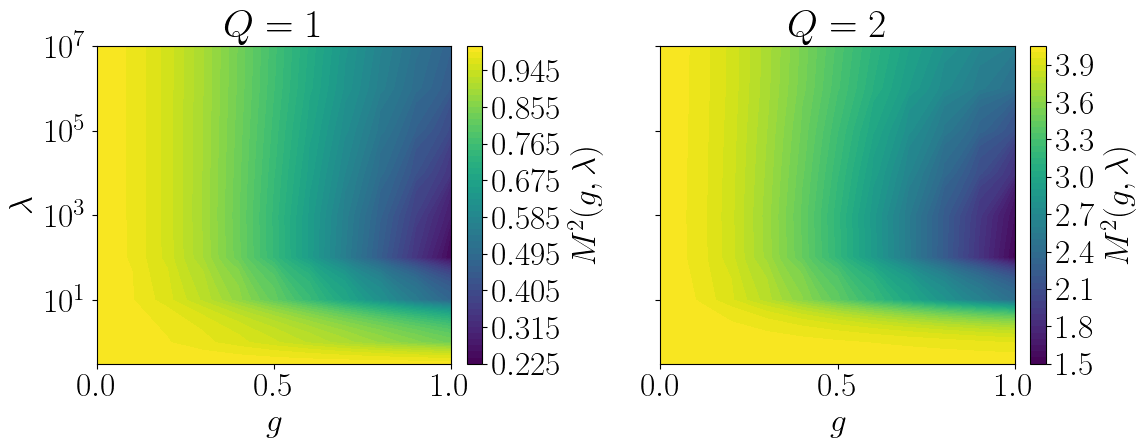

In [127]:
lambdas = 1/np.sqrt(ts)

X, Y = np.meshgrid(lambdas, gs)
fig, ax = plt.subplots(1, 2, figsize = (12, 5), sharey = True)


contour1 = ax[0].contourf(Y, X, ms_Q1, levels=50, cmap='viridis')
contour2 = ax[1].contourf(Y, X, ms_Q2, levels=50, cmap='viridis')


ax[0].set_title(r"$Q = 1$")
ax[0].set_ylabel(r"$\lambda$")
ax[0].set_xlabel(r"$g$")
ax[0].set_yticklabels([1e7])
ax[0].set_yscale('log')

ax[1].set_title(r"$Q = 2$")
ax[1].set_xlabel(r"$g$")
ax[1].set_yscale('log')


cbar1 = fig.colorbar(contour1, ax=ax[0], orientation='vertical', fraction=0.05, pad=0.04)
cbar1.set_label(r"$M^2(g, \lambda)$")

cbar2 = fig.colorbar(contour2, ax=ax[1], orientation='vertical', fraction=0.05, pad=0.04)
cbar2.set_label(r"$M^2(g, \lambda)$")
plt.tight_layout()
plt.show()